# Objetivo 2.1

# Autores
David Rodríguez , Alejandro Meza

# Índice de la práctica

- [1.Introducción](#1.Introducción)
- [2.Creación del dataset](#2.Creación-del-dataset)
- [3.Creación del clasificador](#3.Creación-del-clasificador)
- [4.Algoritmo de ventana deslizante](#4.Algoritmo-de-ventana-deslizante)
- [5.Supresión de no máximos para eliminación de múltiples positivos](#5.Supresión-de-no-máximos-para-eliminación-de-múltiples-positivos)

In [61]:
import cv2
import glob
import skimage


#Librerias contornos 
import numpy as np
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.feature import hog
from skimage import data, exposure

#Machine Learning
from scipy.optimize import minimize
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn import svm

# Ventana Deslizante
import time

# 1.Introducción

El segundo objetivo se ha dividido principalmente en tres tareas:
-    Creación del dataset
-    Creación del clasificador
-    Implementación ventana deslizante con SVM

# 2.Creación del dataset

Primero creamos diccionarios para guardar los parches de las señales* y otra para los parches de no señales (cada identificador tiene asociado su significado).

In [31]:
'''
Descripcion: diccionario con los posibles valores de las imagenes, en relacion con el nombre de las carpetas.
Entrada: -
Salida: diccionario cuyas claves son el nombre de las carpetas, y los valores son el tipo de signals que contiene.
'''
def devolverDiccionarioEtiquetasSign():
    
    diccionarioValores = {}
    diccionarioValores['00000'] = 'VelocidadMaxima20'
    diccionarioValores['00001'] = 'VelocidadMaxima30'
    diccionarioValores['00002'] = 'VelocidadMaxima50'
    diccionarioValores['00003'] = 'VelocidadMaxima60'
    diccionarioValores['00004'] = 'VelocidadMaxima70'
    diccionarioValores['00005'] = 'VelocidadMaxima80'
    diccionarioValores['00006'] = 'FinVelocidadMaxima80'
    diccionarioValores['00007'] = 'VelocidadMaxima100'
    diccionarioValores['00008'] = 'VelocidadMaxima120'
    diccionarioValores['00009'] = 'AdelantamientoProhibido'
    diccionarioValores['00010'] = 'AdelantamientoProhibidoParaCamiones'

    diccionarioValores['00011'] = 'InterseccionConPrioridad'
    diccionarioValores['00012'] = 'CalzadaConPrioridad'
    diccionarioValores['00013'] = 'CedaElPaso'
    diccionarioValores['00014'] = 'DetencionObligatoria'
    diccionarioValores['00015'] = 'CirculacionProhibida'
    diccionarioValores['00016'] = 'EntradaProhibidaAVehiculosMercancias'
    diccionarioValores['00017'] = 'EntradaProhibida'
    diccionarioValores['00018'] = 'OtrosPeligros'
    diccionarioValores['00019'] = 'CurvaPeligrosaHaciaLaIzquierda'
    diccionarioValores['00020'] = 'CurvaPeligrosaHaciaLaDerecha'

    diccionarioValores['00021'] = 'CurvasPeligrosasHaciaLaIzquierda'
    diccionarioValores['00022'] = 'PerfilIrregular'
    diccionarioValores['00023'] = 'PavimentoDeslizante'
    diccionarioValores['00024'] = 'EstrechamientoCalzadaPorDerecha'
    diccionarioValores['00025'] = 'Obras'
    diccionarioValores['00026'] = 'Semaforos'
    diccionarioValores['00027'] = 'PasoDePeatones'
    diccionarioValores['00028'] = 'Kids'
    diccionarioValores['00029'] = 'EntradaProhibidasCiclos'
    diccionarioValores['00030'] = 'PavimentoDeslizanteNieveHielo'

    diccionarioValores['00031'] = 'PasoDeAnimalesEnLibertad'
    diccionarioValores['00032'] = 'FinDeProhibiciones'
    diccionarioValores['00033'] = 'SentidoObligatorioDerecha'
    diccionarioValores['00034'] = 'SentidoObligatorioIzquierda'
    diccionarioValores['00035'] = 'SentidoObligatorio'
    diccionarioValores['00036'] = 'DirPermitidasRectoYDerecha'
    diccionarioValores['00037'] = 'DirPermitidasRectoEIzquierda'
    diccionarioValores['00038'] = 'PasoObligatorioDerecha'
    diccionarioValores['00039'] = 'PasoObligatorioizquierda'
    diccionarioValores['00040'] = 'InterseccionSentidoObligatorioGiratorio'


    diccionarioValores['00041'] = 'FinProhibicionAdelantamiento'
    diccionarioValores['00042'] = 'FinProhibicionAdelantamientoCamiones'
    
    return diccionarioValores

In [32]:
'''
Descripcion: diccionario con los posibles valores de las imagenes, en relacion con el nombre de las carpetas.
Entrada: -
Salida: diccionario cuyas claves son el nombre de las carpetas, y los valores son el tipo de signals que contiene.
'''
def devolverDiccionarioEtiquetasNoSign():
    
    diccionarioValores = {}
    diccionarioValores['000'] = 'Animal'
    diccionarioValores['001'] = 'Carretera'
    diccionarioValores['002'] = 'Cielo'
    diccionarioValores['003'] = 'VehiculoCoche'
    diccionarioValores['004'] = 'Arbol'
    diccionarioValores['005'] = 'Persona'
    diccionarioValores['006'] = 'Edificio'
    diccionarioValores['007'] = 'VehiculoMoto'
    diccionarioValores['008'] = 'Semaforo'
    diccionarioValores['009'] = 'Basura'
    diccionarioValores['010'] = 'Farola'

    diccionarioValores['011'] = 'Estatua'
    diccionarioValores['012'] = 'PasoDeZebra'
    diccionarioValores['013'] = 'Carteles'
    diccionarioValores['014'] = 'Ventana'
    diccionarioValores['015'] = 'Paisaje'
    diccionarioValores['016'] = 'Mix'
    diccionarioValores['017'] = 'Parches creados por programa'
    
    return diccionarioValores

Probemos ahora el código para las no señales....

In [33]:
d =  devolverDiccionarioEtiquetasNoSign()

for k,v in d.items():
    print(v)

Animal
Carretera
Cielo
VehiculoCoche
Arbol
Persona
Edificio
VehiculoMoto
Semaforo
Basura
Farola
Estatua
PasoDeZebra
Carteles
Ventana
Paisaje
Mix
Parches creados por programa


Creamos otros dos diccionarios para almacenar todas las fotos señales y no señales por separado, relaciondolas con su etiqueta correspondiente.

In [34]:
'''
Descripcion: diccionario con los posibles valores de las imagenes, en relacion con el nombre de las carpetas.
Entrada: -
Salida: diccionario cuyas claves son el nombre de las carpetas, y los valores son las imagenes de las signals
'''
def crearDiccionarioDatosSign():
    trafic_signals = {}
    #para cada tipo de señal creamos una lista con sus ejemplos, y se la asignamos a su etiqueta de nombre de carpeta
    for i in range(0,43):
        if i<10:
            folder = 'Dataset_traffic_sign/0000'+str(i)+'/*.png'
            tipo = '0000'+str(i)
        else:
            folder = 'Dataset_traffic_sign/000'+str(i)+'/*.png'
            tipo = '000'+str(i)
        
        images = [cv2.imread(file,0) for file in glob.glob(folder)]
        images_mod = [] 
        for im in images:
            #se aplica el resize
            images_mod.append(cv2.resize(im, (100, 100), interpolation = cv2.INTER_NEAREST))

        trafic_signals[tipo] = images_mod
    return trafic_signals

In [35]:
'''
Descripcion: diccionario con los posibles valores de las imagenes, en relacion con el nombre de las carpetas.
Entrada: -
Salida: diccionario cuyas claves son el nombre de las carpetas, y los valores los elementos que no son signals
'''
def crearDiccionarioDatosNoSign():
    noSignals = {} #diccionario para almacenar todo lo que no es sinal
    #para cada tipo de elemento que no es señal creamos una lista con sus ejemplos
    # y se la asignamos a su etiqueta de nombre de carpeta
    for i in range(0,18): #iteramos sobre el numero de carptas
        if i<10:
            folder = 'Dataset_no_traffic_sign/00'+str(i)+'/*.jpg'
            tipo = '00'+str(i)
        else:
            folder = 'Dataset_no_traffic_sign/0'+str(i)+'/*.jpg'
            tipo = '0'+str(i)

        images = [cv2.imread(file,0) for file in glob.glob(folder)]
        images_mod = [] 
        for im in images:
            #se aplica el resize
            images_mod.append(cv2.resize(im, (100, 100), interpolation = cv2.INTER_NEAREST))

        noSignals[tipo] = images_mod
    return noSignals

Creamos la función para transformar imagenes en descriptores con HOG.*

In [36]:
# HOG
def hogMaker(images00000_mod):
    fd, hog_image = hog(images00000_mod, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True)
    return fd

Cogemos las imagenes y las separamos en train y test, y decimos a que clase pertenecen*. Para eso creamos estas funciones

In [37]:
'''
Descripcion: Obtencion de train y test a partir de un conjunto de imágenes
Entrada: trafic_signals, signals_types
Salida: imagenesTrain,imagenesTest,ytrain,ytest
'''
def separaTrainTest(trafic_signals,signals_types):
    imagenesTrain = None
    imagenesTest = None
    ytrain = None
    ytest = None
    
    for signal,images in trafic_signals.items():
        
        aux_y_train = []
        aux_y_test = []
        
        np_im = np.array(images)
        n_train = int(0.6*np_im.shape[0])
        n_test = np_im.shape[0]-n_train
        
        aux_train = np_im[:n_train]
        aux_test = np_im[n_train:]
        
        for i in range(n_train):
            aux_y_train.append(signals_types[signal])
        for i in range(n_test):
            aux_y_test.append(signals_types[signal])
        
        aux_y_train = np.array(aux_y_train).reshape(-1,1)
        aux_y_test = np.array(aux_y_test).reshape(-1,1)
        
        if imagenesTrain is None:
            imagenesTrain = aux_train
            ytrain = aux_y_train
            imagenesTest = aux_test
            ytest = aux_y_test
        else:
            imagenesTrain = np.concatenate((imagenesTrain,aux_train),axis=0)
            ytrain =  np.vstack((ytrain,aux_y_train))
            imagenesTest = np.concatenate((imagenesTest,aux_test),axis=0)
            ytest = np.vstack((ytest,aux_y_test))
        
    return imagenesTrain,imagenesTest,ytrain,ytest

Creamos las caracteristicas con los datos que nos den y sus tipos*

In [38]:
def creaMatrizCaracteristicas(imagenes,carac_type):
    X = None
        
    for i in range(imagenes.shape[0]):
        if carac_type=='hog':
            d = hogMaker(imagenes[i])
        else: #en caso de recibir un valor que no es valido
            try:
                raise ValueError
            except ValueError:
                print("valor incorrecto")
        
        if d is not None:
            if X is None:
                X = d
            else:
                X = np.vstack((X,d))
    return X

Creamos con las funciones anteriores los diccionarios asociados a señales y no señales.

In [39]:
elem_signals = crearDiccionarioDatosSign() #creacion del diccionario de datos
signals_types = devolverDiccionarioEtiquetasSign() #creacion de diccionario que contiene nombre de carpetas y tipos de signals

elem_no_signals = crearDiccionarioDatosNoSign() #creacion del diccionario de datos
no_signals_types = devolverDiccionarioEtiquetasNoSign() #creacion de diccionario que contiene nombre de carpetas y tipos de signalcarac_type = 'hog' #el tipo elegido para los descriptores va a ser Hog
carac_type = 'hog'

Creamos conjuntos para TRAIN y TEST con las caracteristicas etraidas con HOG sobre señales y no señales, aplicandoles unos filtros gaussianos anteriormente a las imagenes.

In [40]:
signal_Train,signal_Test,signal_ytrain,signal_ytest = separaTrainTest(elem_signals,signals_types)

In [41]:
no_signal_Train,no_signal_Test,no_signal_ytrain,no_signal_ytest = separaTrainTest(elem_no_signals,no_signals_types)

In [42]:
imagenesTrain = np.concatenate((signal_Train, no_signal_Train))
imagenesTest = np.concatenate((signal_Test, no_signal_Test))

Ytrain = np.vstack((signal_ytrain,no_signal_ytrain))
Ytest = np.vstack((signal_ytest,no_signal_ytest))

In [43]:
def filtro_suavizado(imagen, mascara):
    a,b = mascara.shape
    a = (a//2)
    b = (b//2)
    aux = np.zeros_like(imagen)

    #Se crea la imagen ampliada 
    imagen_ampliada = cv2.copyMakeBorder(imagen,a,a,b,b,cv2.BORDER_REPLICATE)

    #Dimensiones de la imagen ampliada
    r,c = imagen_ampliada.shape

    for i in range(a,r-a): #en el bucle no iteras sobre las filas que has ampliado
        for j in range(b,c-b): #en el bucle no iteras sobre las columnas que has ampliado
            vecindad= imagen_ampliada[i-a:i+a+1, j-b: j+b+1]
            aux[i-a,j-b] = np.sum(vecindad * mascara)

    return np.uint8(aux)

n = 3 #tamaño del filtro
sigma = 3 #desviación de la gaussiana
mask = cv2.getGaussianKernel(n, sigma)*cv2.getGaussianKernel(n, sigma).T

imagenesTrain_GK = np.zeros(imagenesTrain.shape)
for i in range(imagenesTrain.shape[0]):
    imagenesTrain_GK[i] = filtro_suavizado(imagenesTrain[i], mask)

imagenesTest_GK = np.zeros(imagenesTest.shape)
for i in range(imagenesTest.shape[0]):
    imagenesTest_GK[i] = filtro_suavizado(imagenesTest[i], mask)
    
Xtrain = creaMatrizCaracteristicas(imagenesTrain_GK,carac_type)
Xtest = creaMatrizCaracteristicas(imagenesTest_GK,carac_type)

Vemos si hay concordancia en los datos.

In [44]:
signal_Train.shape, signal_Test.shape, signal_ytrain.shape, signal_ytest.shape

((739, 100, 100), (525, 100, 100), (739, 1), (525, 1))

In [45]:
no_signal_Train.shape, no_signal_Test.shape, no_signal_ytrain.shape, no_signal_ytest.shape

((7962, 100, 100), (5320, 100, 100), (7962, 1), (5320, 1))

In [46]:
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((8701, 288), (8701, 1), (5845, 288), (5845, 1))

[Indice](#Índice-de-la-práctica)

# 3.Creación del clasificador

A continuación se implementará la SVM para dar solución al problema.

La siguiente funcion nos convertirá cada etiqueta asociada a los distintos objetos en señales y no señales.

In [47]:
def transformarY_SignNoSign(y, dicNoSign):
    Y = np.ones(y.shape[0]).reshape(-1,1)
    
    for signal,nombre in dicNoSign.items():
        for i in range(Y.size):
            if y[i]==nombre:
                Y[i] = 0
    Yfinal = []
    for i in range(Y.size):
        if Y[i] == 1:
            Yfinal.append('Signal')
        else:
            Yfinal.append('No Signal')
    return Yfinal

In [48]:
Ytrain_T = transformarY_SignNoSign(Ytrain, no_signals_types)
Ytest_T = transformarY_SignNoSign(Ytest, no_signals_types)

In [49]:
Ytrain_T = np.array(Ytrain_T)
Ytest_T = np.array(Ytest_T)

Entrenamos la SVM con los datos obtenidos.

In [98]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},]
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid)
clf.fit(Xtrain,Ytrain_T.ravel())
y_pred = clf.predict(Xtest)
print("Classification report for - \n{}:\n{}\n".format(clf, metrics.classification_report(Ytest_T.ravel(), y_pred)))

Classification report for - 
GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}]):
              precision    recall  f1-score   support

   No Signal       1.00      1.00      1.00      5320
      Signal       0.99      0.95      0.97       525

    accuracy                           1.00      5845
   macro avg       0.99      0.98      0.99      5845
weighted avg       1.00      1.00      1.00      5845




Despúes de crear el clasificador, creamos esta funcion la cual le damos una imagen y predice si es o no una señal

In [99]:
def predecirImagenSVM(imagen,carac_type,clf):
#     transformar imagen en des
    d = creaMatrizCaracteristicas(np.array([imagen]), carac_type)
    d = np.array(d).reshape(1,-1)
    return clf.predict(d)

Creamos un pequeño programa (demo) para que se pueda probar de una manera un poco más directa y visual, con los datos de TEST.

¿Desea probar el clasificador? (si/no)si
Introduce un numero de imagen para probar: 345
Tu numero de imagen para probar es la numero 345


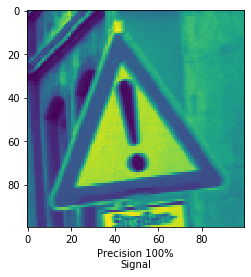

Precision hasta el momento: 100.0%

¿Desea seguir probando el clasificador? (si/no)450


In [90]:
#pequeña celda para interactuar con el clasificador

caracter = input("¿Desea probar el clasificador? (si/no)")
nDeAciertos = 0
nDeSignalsEjecutadas = 0
if caracter == "no":
    print("Hasta la proxima!!")
elif caracter == "si":
    while(caracter == "si"):
        nDeSignalsEjecutadas+=1
        numeroImagen = (int)(input("Introduce un numero de imagen para probar: "))
        print(f"Tu numero de imagen para probar es la numero {numeroImagen}")
        res = predecirImagenSVM(imagenesTest[numeroImagen],carac_type,clf)
        plt.figure()
        plt.imshow(imagenesTest[numeroImagen])
        lab = 'Precision 100%\n'+ res[0]
        plt.xlabel(lab)
        plt.show()
        if Ytest_T[numeroImagen]==res:
            nDeAciertos+=1
        print(f"Precision hasta el momento: {(nDeAciertos/nDeSignalsEjecutadas)*100}%\n")
        caracter = input("¿Desea seguir probando el clasificador? (si/no)")
        if caracter == "no":
            print("Hasta la proxima!!")
            break

Como resumen de la primera parte, podemos obserbar que los resultados son muy buenos, casi rozando la perfección. Por el contrario el tiempo que tarda en aprender es bastante debido al gran numero de parches-ejemplos entrenados, y especialmente al suavizado de cada imagen, ya que tiene que ir pixel a pixel para cada imagen aplicando el filtro. Si pusiesemos menos datos o si no le aplicasemos el filtro tardaría menos, pero hay una alta probabilidad de que perdamos precisión en el modelo (lo hemos comprobado anteriormente).

[Indice](#Índice-de-la-práctica)

# 4.Algoritmo de ventana deslizante

Para buscar en la imagen una señal, vamos a recorrer la imagen con una ventana la cual va a variar el tamaño en busca de las señales

In [100]:
def sliding_window(image, entreVentanas, windowSize):
    # slide a window across the image
    for j in range(0, image.shape[0], entreVentanas):
        for i in range(0, image.shape[1], entreVentanas):
            # yield the current window
            yield (i, j, image[j:j + windowSize[1], i:i + windowSize[0]])

Paso a paso vamos a ver como recorre la imagen:

Cogemos una imagen:

In [92]:
imagen_sin_color = cv2.imread('Dataset_images/00012.jpg',0)
imagen_a_color = cv2.imread('Dataset_images/00012.jpg')

Se recorrerá la imagen, con un tamaño de ventana cuadrada igual al menor lado de la imagen, la cual ira disminuyendo (entre 1.5) hasta ser de lado 30 o menor, el cual es un tamaño tan pequeño que creemos que es conveniente parar. Aparecerán los diferentes tamaños de la ventana al ejecutarse.
También mencionar que la separacion entre ventana y ventana será de la mitad del lado de la ventana-parche que se esté estudiando.
(este codigo lo hace de manera visual)

In [101]:
if imagen_sin_color.shape[0]<imagen_sin_color.shape[1]:
    winH = int(imagen_sin_color.shape[0])
else:
    winH = int(imagen_sin_color.shape[1])
winW = winH
step = int(winW/2)
# print(winW,winH,step)
result = []
while winW>30 and winH>30:
    print(f'Tamaño de la ventana: {winW}x{winH}')
    # loop over the sliding window for each layer of the pyramid
    for (x, y, window) in sliding_window(imagen_sin_color, step, windowSize=(winW, winH)):
        # if the window does not meet our desired window size, ignore it
        if x+winW<=imagen_sin_color.shape[1] and y+winH<=imagen_sin_color.shape[0]:
            res = predecirImagenSVM(cv2.resize(window, (100, 100), interpolation = cv2.INTER_NEAREST),carac_type,clf)
            clone = imagen_sin_color.copy()
            cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
            cv2.imshow("Window", clone)
            if res=='Signal':
                result.append(np.array([x,y,winW,winH]))
            else:
                cv2.waitKey(1)
                time.sleep(0.001)
    cv2.destroyAllWindows()
    winW = int(winW/1.5)
    winH = winW
    step = int(winW/2)

Tamaño de la ventana: 800x800
Tamaño de la ventana: 533x533
Tamaño de la ventana: 355x355
Tamaño de la ventana: 236x236
Tamaño de la ventana: 157x157
Tamaño de la ventana: 104x104
Tamaño de la ventana: 69x69
Tamaño de la ventana: 46x46


# 5.Supresión de no máximos para eliminación de múltiples positivos

Puede que prediga con diferentes tamaños de ventada la señal, con este codigo eliminamos estos casos (vemos si los centros de cada parche predicho estan dentro de otro. En ese caso los suprimimos.

In [102]:
n_result = []
repetidos = []
for i in range(len(result)):
    x,y,winW,winH = result[i]
    for j in range(len(result)):
        centroX = int(result[j][0]+result[j][2]/2)
        centroY = int(result[j][1]+result[j][3]/2)
        if i!=j and centroX>=x and centroY>=y and centroX<=x+winW and centroY<=y+winH:
            repetidos.append(j)
            
for i in range(len(result)):
    if i not in repetidos:
        n_result.append(result[i])

In [103]:
result

[array([156, 364, 104, 104]),
 array([104, 624, 104, 104]),
 array([136, 544,  69,  69])]

In [104]:
n_result

[array([156, 364, 104, 104]),
 array([104, 624, 104, 104]),
 array([136, 544,  69,  69])]

In [105]:
clone = imagen_a_color.copy()
print(str(len(n_result)))
for i in range(len(n_result)):
    x,y,winW,winH = n_result[i]
    cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
    cv2.putText(clone,'Signal', (x,y-10), cv2.FONT_HERSHEY_PLAIN,.7,(0, 255, 0))
    cv2.imshow("Window", clone)
cv2.waitKey(0)
cv2.destroyAllWindows()

3


*(como en el Objetivo1)

[Indice](#Índice-de-la-práctica)

Como podemos apreciar, el resultado en este ejemplo es algo favorable, pero este es uno de los pocos que interpreta más o menos bien apesar de la alta precision que muestra en el test.